In [ ]:
from dataclasses import dataclass
from datetime import datetime

import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:
batch_size = 256

nz = 100 
ngf = 32 
ngpu = 1

niter = 520

prefix = f"fuzzy_gan_anomaly_detection"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load MNIST

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [ ]:
def get_target_and_mask(target_label):
    """
    Args:
    
    Returns:
    
    """
    
    t = torch.zeros(10)
    t[target_label] = 1.0
    
    return t.to(device) 

In [ ]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(train_data)

In [ ]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

In [ ]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)


### Load EMNIST

In [ ]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.zip")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]

len(emnist_x)

emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))

emnist_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.stack(emnist_x), torch.Tensor(np.array(emnist_y))), 
    batch_size=batch_size, 
    shuffle=False,
)

## DCGAN Model

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
#netG.load_state_dict(torch.load('weights/netG_epoch_99.pth'))
print(netG)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, 1, 2, 1, 1, bias=False),
            nn.BatchNorm2d(1),
            nn.Flatten(),
            nn.Linear(16, 2),
        )
        self.latent_dim = 2
        self.fuzzlets = 10
        
        self.real = nn.Sequential(
            FuzzyLayer.from_dimensions(self.latent_dim, self.fuzzlets),
            DefuzzyLinearLayer.from_array(np.repeat([2.0/self.fuzzlets], self.fuzzlets).reshape(1,-1), trainable=False, with_norm=False)
        )
        self.fake = nn.Sequential(
            FuzzyLayer.from_dimensions(self.latent_dim, self.fuzzlets),
            DefuzzyLinearLayer.from_array(np.repeat([-3.0/self.fuzzlets], self.fuzzlets).reshape(1,-1), trainable=False, with_norm=False)
        )
    

    def forward(self, input):
        #batch_size = input.shape[0]
        output = self.main(input)
        r = self.real(output)
        f = self.fake(output)
        
        return (r+f).squeeze()
    
    def arate(self, input):
        output = self.main(input)
        r = self.real(output)
        f = self.fake(output)
        return (r+f).squeeze()
    

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
num_params = sum(p.numel() for p in netD.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
print(netD)

In [187]:
inp = torch.rand(4, 1, 28, 28).to(device)
dd = Discriminator(1).to(device)
dd(inp)

tensor([[-0.0455],
        [-0.1539],
        [-0.1168],
        [-0.1316]], device='cuda:0', grad_fn=<AddBackward0>)

## Train

In [ ]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.00005, betas=(0.9, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.00005, betas=(0.9, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
def keep_eigenvals_positive_loss(layer, eps = 1e-3):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [ ]:
def get_test_arate_distr(D):
    with torch.no_grad():
        firing_levels = []
        lab_true = []
        lab_pred = []

        for data, _ in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = D.arate(data)
            firing_levels.append(rates.cpu().numpy())
            

        firing_levels = np.concatenate(firing_levels, axis=0)
        for p in firing_levels:
            lab_true.append(1)
            lab_pred.append(p)

        for data, labels in tqdm(emnist_loader, desc='Test EMNIST', disable=True):
            data = data.view((-1, 1, 28, 28)).to(device) 
            arate = D.arate(data)
            
            for p in arate.cpu().numpy():
                lab_true.append(0)
                lab_pred.append(p)
                    
        fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
        roc_auc = metrics.auc(fpr, tpr)

        return firing_levels, roc_auc

def draw_embeddings(epoch):
    with torch.no_grad():
        centroids_real = netD.real[0].get_centroids().detach().cpu().numpy()
        centroids_fake = netD.fake[0].get_centroids().detach().cpu().numpy()
        
        embedings = []
        embedings_test = []
        labels_expected = []
        
        cnt = 3
    
        for data, target in tqdm(train_loader, desc='Encoding', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            embeding = netD.main(data)
            embedings.append(embeding.cpu().numpy())
            labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
            cnt -= 1
            if cnt < 0:
                break
            
        embedings = np.concatenate(embedings, axis=0)
        labels_expected = np.concatenate(labels_expected, axis=0)

        cnt = 3
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc='Encoding', disable=True):
                data = data.view((-1,1,28,28)).to(device)
                embeding = netD.main(data)
                embedings_test.append(embeding.cpu().numpy())
                cnt -= 1
                if cnt < 0:
                    break
        embedings_test = np.concatenate(embedings_test, axis=0)

        embedings_fake = []

    
        batch_size = 256
        latent_size = 100
        
        fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
        if torch.cuda.is_available():
            fixed_noise = fixed_noise.cuda()
        fake_images = netG(fixed_noise)
        embeding = netD.main(fake_images)
        embedings_fake.append(embeding.cpu().numpy())

        embedings_fake = np.concatenate(embedings_fake, axis=0)    

        plt.figure(figsize=(12, 6))

        R, C = 1, 2

        plt.subplot(R, C, 1)
        plt.scatter(embedings[:, 0], embedings[:, 1], c=labels_expected, cmap='tab10', s=16)
        plt.scatter(embedings_test[:, 0], embedings_test[:, 1], marker='+', c='red', s = 1)
        
        plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='black', marker='o', s=16)
        plt.scatter(centroids_real[:, 0], centroids_real[:,1], marker='1', c='green', s= 120)
        plt.scatter(centroids_fake[:, 0], centroids_fake[:,1], marker='2', c='red', s= 120)
        plt.subplot(R, C, 2)
        plt.scatter(embedings_test[:, 0], embedings_test[:, 1], c='red', s=20)
        plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='black', marker='o', s=20)
        plt.scatter(centroids_real[:, 0], centroids_real[:,1], marker='1', c='green', s= 120)

        plt.show()
    #writer.add_figure('Embeddings', fig, epoch)

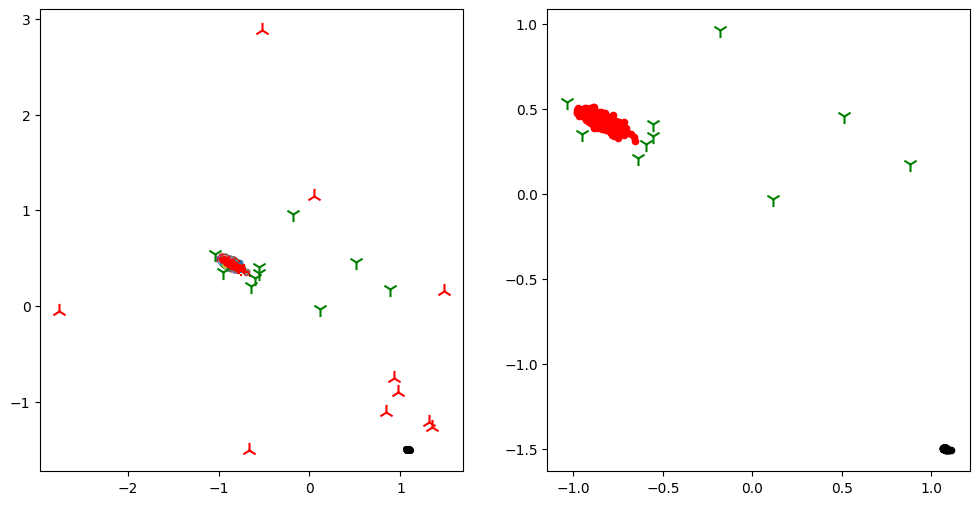

Epoch 0/520
{'G': 1.0007275274459353, 'POS': 0.9999938891289082, 'NEG': -0.9997373689996435, 'EV': 0.0, 'q20': 0.9994362831115723, 'q80': 1.0004914045333861, 'auc': 0.9997889396718146}


KeyboardInterrupt: 

In [162]:
netG.train()
netD.train()

for epoch in range(niter):
    report_aver_pos = 0
    report_aver_neg = 0
    report_loss_G = 0
    report_ev = 0
    local_count = 0
    
    for i, data in enumerate(tqdm(train_loader, desc='Training', disable=True)):
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        
        netD.zero_grad()
        
        firing = netD(real_cpu)
        errD_real = torch.square(1 - firing).mean()
        errD_real.backward(retain_graph=True)
        ev_loss = keep_eigenvals_positive_loss(netD.real[0])
        ev_loss.backward()
        report_ev = np.maximum(report_ev, ev_loss.item())
        
        nfiring = netD(fake.detach())
        errD_fake = torch.square(1 + nfiring).mean()
        errD_fake.backward(retain_graph=True)
        ev_loss = keep_eigenvals_positive_loss(netD.fake[0])
        ev_loss.backward()
        report_ev = np.maximum(report_ev, ev_loss.item())
        
        optimizerD.step()
        
        netD.zero_grad()
        netG.zero_grad()
        genr = netD(fake)
        errG = torch.square(genr).mean() 
        errG.backward()
        optimizerG.step()
        
        local_count += 1
        report_loss_G += errG.item()
        report_aver_pos += firing.mean().item()
        report_aver_neg += nfiring.mean().item()
        
    with torch.no_grad():
        losses = {}
        
        losses['G'] = report_loss_G / local_count
        losses['POS'] = report_aver_pos / local_count
        losses['NEG'] = report_aver_neg / local_count
        losses['EV'] = report_ev
        
        writer.add_scalars('Loss', losses, epoch)
        fake = netG(fixed_noise)
        writer.add_images('Generated images', fake.detach(), epoch)
        draw_embeddings(epoch)    
        
        mnist_distr, auc = get_test_arate_distr(netD)
        mnist_distr_q = {}
        mnist_distr_q["q20"] = np.quantile(mnist_distr, 0.2)
        mnist_distr_q["q80"] = np.quantile(mnist_distr, 0.8)
        writer.add_scalars("MNIST test  firings", mnist_distr_q, epoch)
        writer.add_scalar("AUC", auc, epoch)
        mnist_distr_q["auc"] = auc
        
        print(f"Epoch {epoch}/{niter}")
        print({**losses, **mnist_distr_q})
    
#draw_embeddings(epoch)
#num_gpu = 1 if torch.cuda.is_available() else 0

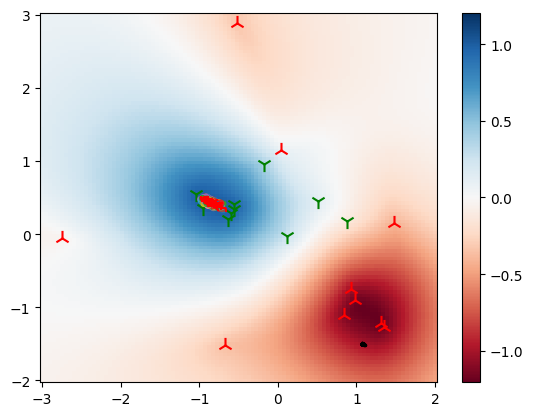

In [163]:
centroids_real = netD.real[0].get_centroids().detach().cpu().numpy()
centroids_fake = netD.fake[0].get_centroids().detach().cpu().numpy()
    
embedings = []
embedings_test = []
labels_expected = []
    
cnt = 3
with torch.no_grad():
    for data, target in tqdm(train_loader, desc='Encoding', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        embeding = netD.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
        cnt -= 1
        if cnt < 0:
            break
        
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)

cnt = 3
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        embeding = netD.main(data)
        embedings_test.append(embeding.cpu().numpy())
        cnt -= 1
        if cnt < 0:
            break
embedings_test = np.concatenate(embedings_test, axis=0)

embedings_fake = []

with torch.no_grad():
    batch_size = 256
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = netG(fixed_noise)
    embeding = netD.main(fake_images)
    embedings_fake.append(embeding.cpu().numpy())

embedings_fake = np.concatenate(embedings_fake, axis=0)    

szw = 100
mesh = []
for x in np.linspace(-3, 2, num=szw):
    for y in np.linspace(-2, 3, num=szw):
        mesh.append([x,y])
x = np.array([a[0] for a in mesh]).reshape((szw,szw))
y = np.array([a[1] for a in mesh]).reshape((szw,szw))
inp = torch.FloatTensor(mesh).reshape((-1, 2)).to(device)
z = (netD.real(inp)+netD.fake(inp)).detach().cpu().numpy().reshape((szw,szw))

#plt.imshow(z.reshape((szw,szw)), cmap='hot', interpolation='nearest')
#plt.show()
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
#ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.scatter(centroids_real[:, 0], centroids_real[:,1], marker='1', c='green', s= 120)
ax.scatter(centroids_fake[:, 0], centroids_fake[:,1], marker='2', c='red', s= 120)
ax.scatter(embedings[:, 0], embedings[:, 1], c=labels_expected, cmap='tab10', s=16)
ax.scatter(embedings_test[:, 0], embedings_test[:, 1], marker='+', c='red', s = 1)
ax.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='black', marker='o', s=2)

fig.colorbar(c, ax=ax)


In [164]:
netD.real(torch.tensor([[0.75, -0.6]]).to(device)).item()

0.5041635036468506

In [165]:
netD.real[0].get_centroids()

tensor([[-0.5542,  0.3416],
        [-1.0379,  0.5418],
        [-0.1795,  0.9610],
        [-0.5532,  0.4087],
        [ 0.8804,  0.1752],
        [-0.6409,  0.2119],
        [-0.9502,  0.3504],
        [ 0.5150,  0.4548],
        [ 0.1174, -0.0332],
        [-0.5933,  0.2944]], device='cuda:0', grad_fn=<LinalgSolveExBackward0>)

In [166]:
netD.real[0].get_transformation_matrix()

tensor([[[ 0.7957, -0.1706,  0.4992],
         [-0.1706,  1.1845, -0.4992],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.2308, -0.2061,  1.3892],
         [-0.2061,  1.0522, -0.7840],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.5789, -0.3760,  0.4652],
         [-0.3760,  1.4436, -1.4548],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.6593,  0.2046,  0.2811],
         [ 0.2046,  1.2005, -0.3775],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.5920,  0.0610, -0.5319],
         [ 0.0610,  1.2757, -0.2772],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.8951,  0.1742,  0.5368],
         [ 0.1742,  0.7457, -0.0463],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.9969,  0.3296,  0.8318],
         [ 0.3296,  0.6315,  0.0919],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.5827,  0.0444, -0.3203],
         [ 0.0444,  1.2904, -0.6098],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.6991,  0.1420, -0.0774],
         [ 0.1420,  1.0851,  0.019

## Валидация

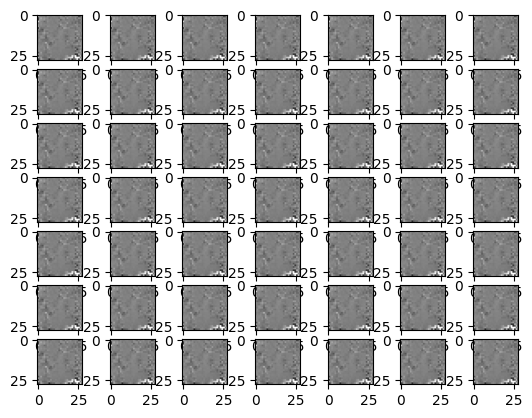

In [167]:
D = netD
G = netG

with torch.no_grad():
    batch_size = 49
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = G(fixed_noise)

    fake_images_np = fake_images.cpu().detach().numpy()
    fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
    R, C = 7, 7
    for i in range(batch_size):
        plt.subplot(R, C, i + 1)
        plt.imshow(fake_images_np[i], cmap='gray')
    plt.show()

In [189]:
def get_arate(inp):
    #output = D.main(inp)
    #c = D.core(output)
    return D.arate(inp).squeeze()
inp = torch.rand((2,1,28,28))
get_arate(inp.to(device))

tensor([-1.1872, -1.1841], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [190]:
centroids_r = D.real[0].get_centroids().detach().cpu().numpy()
#centroids_f = D.fake[0].centroids.squeeze(-1).cpu().detach().numpy()
#centroids_r

In [191]:
embedings_fake = []

with torch.no_grad():
    batch_size = 256
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = G(fixed_noise)
    embeding = D.main(fake_images)
    embedings_fake.append(embeding.cpu().numpy())

embedings_fake = np.concatenate(embedings_fake, axis=0)    

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

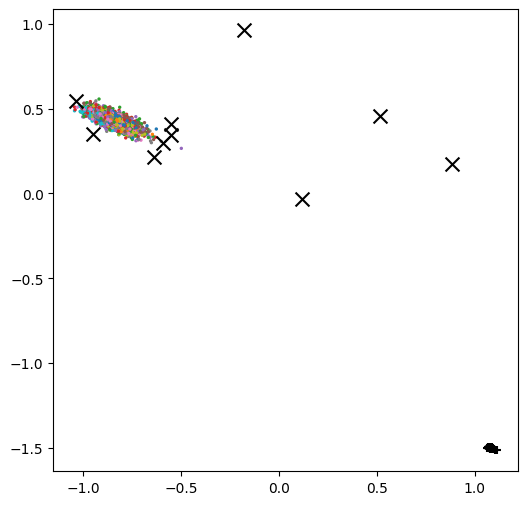

In [192]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
plt.figure(figsize=(6, 6))

R, C = 1, 1
cnt = 1
for i in range(1):
    plt.subplot(R, C, cnt)
    cnt += 1
    plt.scatter(embedings_fake[:, 2*i], embedings_fake[:, 2*i+1], c='black', marker='+', s=30)
    plt.scatter(embedings[:, 2*i], embedings[:, 2*i+1], c=labels_expected, cmap='tab10', s=2)
    plt.scatter(centroids_r[:,2*i], centroids_r[:,2*i+1], marker='x', c='black', s= 100)
    #plt.scatter(centroids_f[:,2*i], centroids_f[:,2*i+1], marker='o', c='red', s= 20)
    #plt.xlim(-0.5, 0.5)
    #plt.ylim(-0.5, 0.5)
#plt.colorbar()
plt.show()



Encoding:   0%|          | 0/405 [00:00<?, ?it/s]

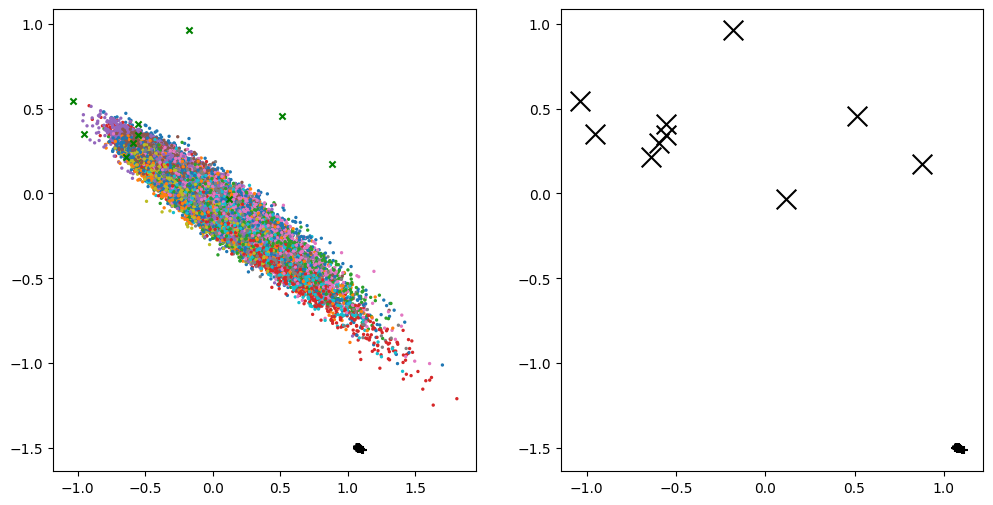

In [193]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(target.cpu().numpy())
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
plt.figure(figsize=(12, 6))

R, C = 1, 2

plt.subplot(R, C, 1)
plt.scatter(embedings_fake[:, 2*i], embedings_fake[:, 2*i+1], c='black', marker='+', s=30)
plt.scatter(embedings[:, 2*i], embedings[:, 2*i+1], c=labels_expected, cmap='tab10', s=2)
plt.scatter(centroids_r[:,2*i], centroids_r[:,2*i+1], marker='x', c='green', s= 20)
plt.subplot(R, C, 2)
plt.scatter(embedings_fake[:, 2*i], embedings_fake[:, 2*i+1], c='black', marker='+', s=30)
plt.scatter(centroids_r[:,2*i], centroids_r[:,2*i+1], marker='x', c='black', s= 200)

plt.show()

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

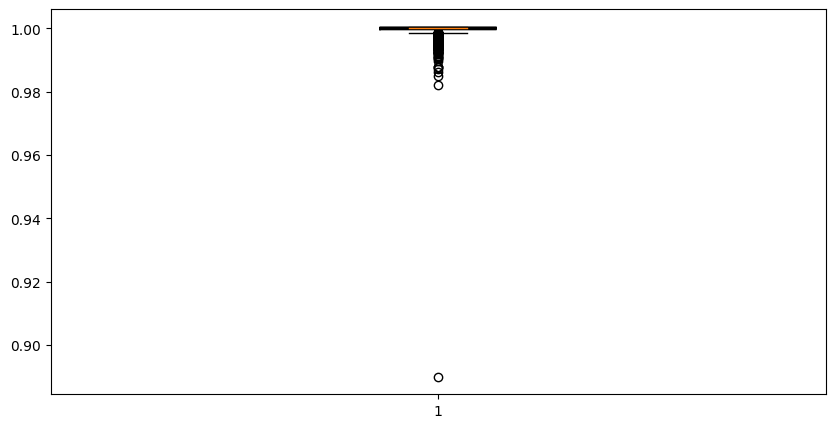

In [194]:
firing_levels = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        #output = D.main(data)
        #r = D.real(output)
        #rates = r

        firing_levels.append(rates.cpu().numpy())
        
firing_levels = np.concatenate(firing_levels, axis=0)
fig = plt.figure(figsize =(10, 5))
plt.boxplot(firing_levels, notch=True, showfliers=True)
plt.show()

In [195]:
firings_emnist = {}
for m in emnist_mapping:
    firings_emnist[emnist_mapping[m]] = []

with torch.no_grad():
    for data, labels in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1, 1, 28, 28)).to(device) 
        arate = get_arate(data)
        #output = D.main(data)
        #r = D.real(output)
        #arate = 1 - r.sum(dim = 1)
        
        for label, flabel in zip(labels, arate.cpu().numpy()):
            firings_emnist[emnist_mapping[label.item()]].append(flabel)

Encoding:   0%|          | 0/405 [00:00<?, ?it/s]

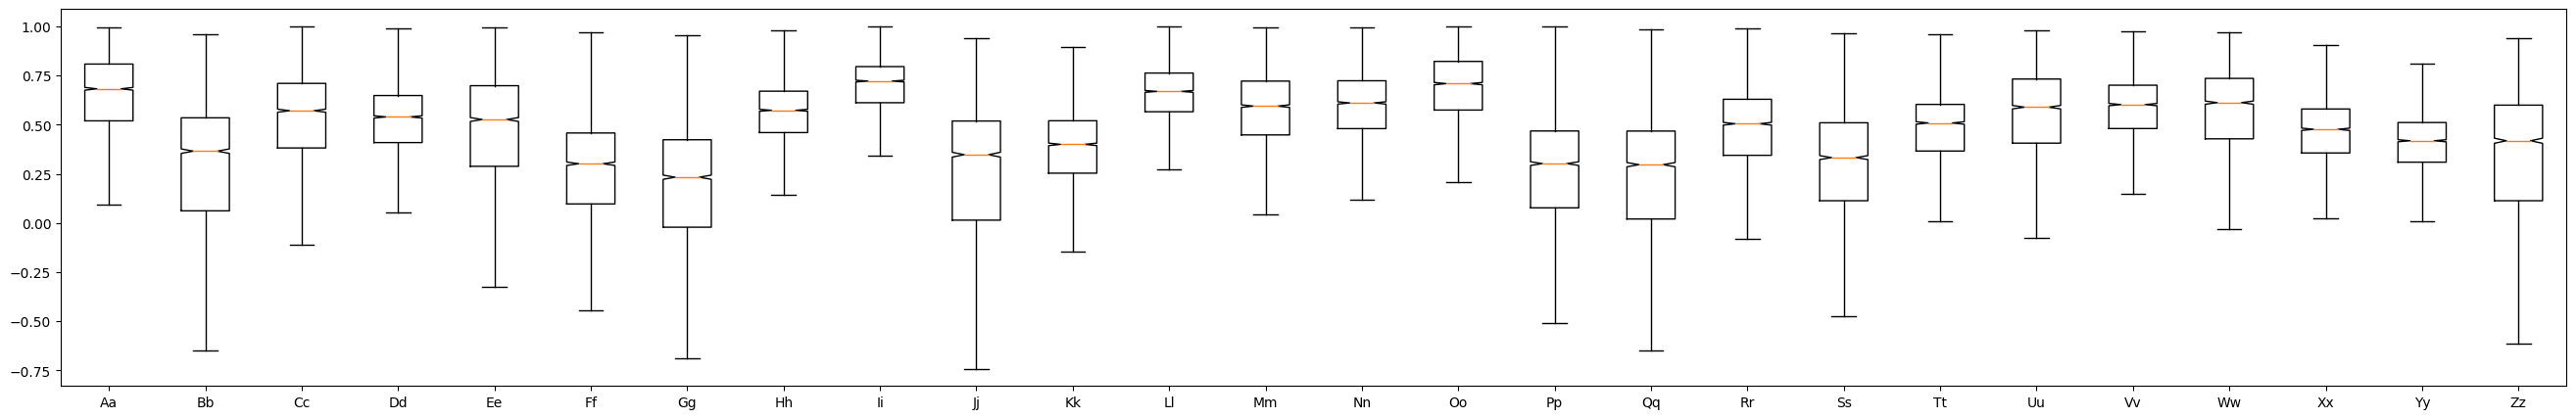

In [196]:
labels, data = firings_emnist.keys(), firings_emnist.values()
fig = plt.figure(figsize =(33, 5))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

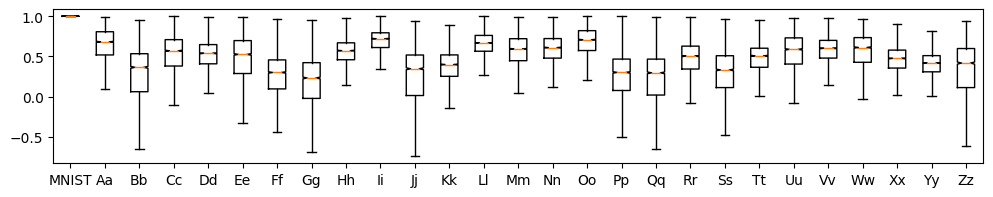

In [197]:
firings_mnist = {}
firings_mnist['MNIST'] = firing_levels
firings = {**firings_mnist, **firings_emnist} 
labels, data = firings.keys(), firings.values()

fig = plt.figure(figsize =(12, 2))
#plt.ylim(ymin=0)
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

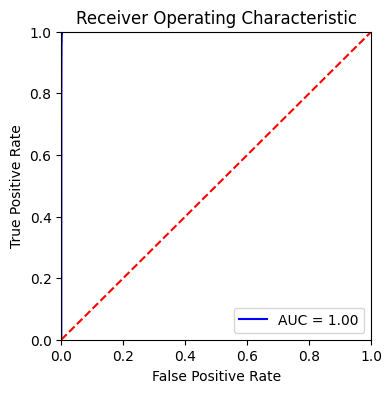

In [198]:
lab_true = []
lab_pred = []
for k,v in firings_mnist.items():
    for p in v:
        lab_true.append(1)
        lab_pred.append(p)
for k,v in firings_emnist.items():
    if k == 'Oo':
        continue
    for p in v:
        lab_true.append(0)
        lab_pred.append(p)

fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize =(4, 4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
writer.add_figure('ROC', fig)